In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

#### Simulation setup

In [2]:
sim = rw.Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**3
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
energy = 3*10**15 # eV
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions
        

source = rw.PointSourceOriented(energy, source_pos, nr_particles, pitch_angle, phi)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  1000
energy:  3000000000000000  eV
source tpye: PointSourceOriented
pitch angle:  0.955393232541696
phi:  0.0


#### Propagator

In [4]:
nr_steps = 1*10**4
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
rms = 1 # Gaus
magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
#propagator.set_pitch_angle_const(False)
sim.add_propagator(propagator)
sim.propagator.get_description()

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

propagation tpye: AnisotropicPropagator
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle sp

#### Observer

In [15]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200
spheres = [5*10**12]

#observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
observer = rw.SphericalObserver(substeps, spheres)

sim.add_observer(observer)
sim.observer.get_description()

number steps:  0
Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: SphericalObserver
spheres:  [-1.e+00  5.e+12]
steps [0:10]:  []
steps [-11:-1]:  []
nr steps:  0
substeps:  [False False  True]
all_steps:  False


In [16]:
%time sim.run_simulation()
sim.save_data('data/data_sim')

CPU times: user 17.3 s, sys: 8.3 ms, total: 17.3 s
Wall time: 17.3 s


## Analyze statistics


In [17]:
df = pd.read_pickle("data/data_sim.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
sta = rw.Statistics(df_time_evolution_observer)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

init statistics plotting class


ZeroDivisionError: division by zero

In [ ]:
bins = 30
file_name = None
df_kappas = sta.plot_distribution('d', -1, bins, file_name)

In [19]:
df = pd.read_pickle("data/data_sim.pkl")
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,5278.0,3.547547e+13,-1.083891e+11,-4.799609e+10,4.999301e+12,-28.881626,0.955393,5.000000e+12,2.0
1,1.0,3100.0,2.286335e+13,-5.272637e+11,-2.860544e+11,4.964667e+12,109.227875,0.955393,5.000000e+12,2.0
2,1.0,5641.0,3.755579e+13,-3.383673e+11,1.206308e+11,4.984870e+12,32.729218,0.955393,5.000000e+12,2.0
3,1.0,8228.0,5.249496e+13,9.744849e+10,2.599989e+11,4.993529e+12,-20.886639,0.955393,5.000000e+12,2.0
4,2.0,4214.0,2.931937e+13,-2.029637e+11,3.155034e+11,4.987756e+12,13.091575,0.955393,5.000000e+12,2.0
...,...,...,...,...,...,...,...,...,...,...
2317,997.0,1732.0,1.499926e+13,-1.662171e+11,-8.708074e+10,4.999301e+12,1.898782,0.955393,5.000000e+12,2.0
2318,997.0,1931.0,1.614529e+13,-5.710904e+10,-1.129554e+11,4.996415e+12,-2.548364,0.955393,5.000000e+12,2.0
2319,997.0,2384.0,1.873483e+13,1.634842e+11,-5.317526e+11,4.970439e+12,-20.187073,0.955393,5.000000e+12,2.0
2320,998.0,5196.0,2.503586e+13,-5.381726e+11,1.504193e+11,-4.970439e+12,28.381939,0.955393,5.000000e+12,2.0


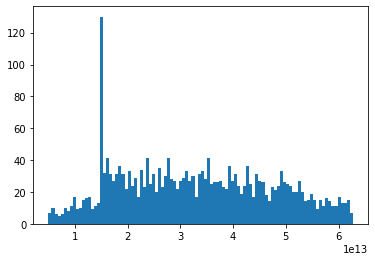

In [20]:
plt.hist(df['d'], bins = 100)
plt.show()

In [11]:
tra = rw.Trajectory(df_time_evolution_observer)
particle_ids = tra.get_particle_ids()
nr_steps = 100
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)
tra.plot_trajectory('d', 'z', 'd', particle_ids[0], nr_steps, None)

init trajectory plotting class


IndexError: list index out of range